In [34]:
# import necessary modules from keras
from keras.layers import Dense
from keras.models import Sequential

# creates a generic neural network architecture
model = Sequential()

# hidden layer takes a pre-processed frame as input, and has 200 units
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))

# output layer
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))

# compile the model using traditional Machine Learning losses and optimizers
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
!pip show gym

Name: gym
Version: 0.16.0
Summary: The OpenAI Gym: A toolkit for developing and comparing your reinforcement learning agents.
Home-page: https://github.com/openai/gym
Author: OpenAI
Author-email: gym@openai.com
License: UNKNOWN
Location: /Users/hannesengelbrecht/Library/Python/2.7/lib/python/site-packages
Requires: cloudpickle, six, pyglet, scipy, numpy, enum34
Required-by: 
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [97]:
!pip show numpy

Name: numpy
Version: 1.16.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /Users/hannesengelbrecht/Library/Python/2.7/lib/python/site-packages
Requires: 
Required-by: opencv-python, matplotlib, h5py, gym, atari-py
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
import gym
import numpy as np

# gym initialization
env = gym.make("Pong-v0")
observation = env.reset()
prev_input = None

# Macros
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

In [36]:
# preprocessing used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def prepro(I):
    """prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector"""
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

# reward discount used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def discount_rewards(r, gamma):
    """ take 1D float array of rewards and compute discounted reward """
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    # we go from last reward to first one so we don't have to do exponentiations
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
        running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
        discounted_r[t] = running_add
    discounted_r -= np.mean(discounted_r) #normalizing the result
    discounted_r /= np.std(discounted_r) #idem
    return discounted_r

In [37]:
# from karpathy import prepro, discount_rewards
reward_sum_history = []

# main loop
# while (True):
while episode_nb < 3000:

    # preprocess the observation, set input as difference between images
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    # forward the policy network and sample action according to the proba distribution
    proba = model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == 2 else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    reward_sum += reward
    
    # end of an episode
    if done:
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
#         print(f'cur_input: {cur_input}, prev_input = {prev_input}, x = {x}, action = {action}, proba = {proba}')
#         print(f'x_train = {x_train}, y_train = {y_train}')
#         print(f'reward = {reward}')
        
        reward_sum_history.append(reward_sum)
        
        # increment episode number
        episode_nb += 1
        
        # training
        model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
                                                             
        # Reinitialization
        x_train, y_train, rewards = [],[],[]
        observation = env.reset()
        reward_sum = 0
        prev_input = None

At the end of episode 0 the total reward was : -18.0
Epoch 1/1
1885/1885 [==============================] - 1s 368us/step - loss: -0.0017 - accuracy: 0.4966
At the end of episode 1 the total reward was : -21.0
Epoch 1/1
1090/1090 [==============================] - 0s 336us/step - loss: -0.0016 - accuracy: 0.5761
At the end of episode 2 the total reward was : -20.0
Epoch 1/1
1393/1393 [==============================] - 0s 306us/step - loss: -0.0187 - accuracy: 0.5901
At the end of episode 3 the total reward was : -21.0
Epoch 1/1
1355/1355 [==============================] - 0s 320us/step - loss: -0.0143 - accuracy: 0.6494
At the end of episode 4 the total reward was : -21.0
Epoch 1/1
1338/1338 [==============================] - 0s 310us/step - loss: 0.0080 - accuracy: 0.6487
At the end of episode 5 the total reward was : -20.0
Epoch 1/1
1479/1479 [==============================] - 0s 318us/step - loss: 7.0916e-04 - accuracy: 0.6430
At the end of episode 6 the total reward was : -21.0
Epo

1678/1678 [==============================] - 1s 415us/step - loss: 0.0037 - accuracy: 0.8814
At the end of episode 104 the total reward was : -21.0
Epoch 1/1
1515/1515 [==============================] - 1s 340us/step - loss: -0.0153 - accuracy: 0.8772
At the end of episode 105 the total reward was : -19.0
Epoch 1/1
1702/1702 [==============================] - 1s 341us/step - loss: 0.0097 - accuracy: 0.9001
At the end of episode 106 the total reward was : -21.0
Epoch 1/1
1583/1583 [==============================] - 1s 319us/step - loss: -0.0034 - accuracy: 0.8800
At the end of episode 107 the total reward was : -20.0
Epoch 1/1
1468/1468 [==============================] - 1s 417us/step - loss: 0.0153 - accuracy: 0.8842
At the end of episode 108 the total reward was : -21.0
Epoch 1/1
1888/1888 [==============================] - 1s 440us/step - loss: -0.0043 - accuracy: 0.9094
At the end of episode 109 the total reward was : -21.0
Epoch 1/1
1585/1585 [==============================] - 1s 5

1617/1617 [==============================] - 0s 293us/step - loss: 0.0011 - accuracy: 0.9041
At the end of episode 156 the total reward was : -21.0
Epoch 1/1
1032/1032 [==============================] - 0s 292us/step - loss: 0.0223 - accuracy: 0.9070
At the end of episode 157 the total reward was : -21.0
Epoch 1/1
1096/1096 [==============================] - 0s 301us/step - loss: 0.0023 - accuracy: 0.9033
At the end of episode 158 the total reward was : -20.0
Epoch 1/1
1695/1695 [==============================] - 0s 278us/step - loss: 0.0125 - accuracy: 0.9156
At the end of episode 159 the total reward was : -21.0
Epoch 1/1
1191/1191 [==============================] - 0s 300us/step - loss: 0.0086 - accuracy: 0.9118
At the end of episode 160 the total reward was : -21.0
Epoch 1/1
1027/1027 [==============================] - 0s 298us/step - loss: 0.0391 - accuracy: 0.8880
At the end of episode 161 the total reward was : -21.0
Epoch 1/1
1119/1119 [==============================] - 0s 297u

1672/1672 [==============================] - 0s 283us/step - loss: 0.0031 - accuracy: 0.9079
At the end of episode 208 the total reward was : -20.0
Epoch 1/1
1382/1382 [==============================] - 0s 283us/step - loss: 0.0259 - accuracy: 0.8980
At the end of episode 209 the total reward was : -21.0
Epoch 1/1
1539/1539 [==============================] - 0s 288us/step - loss: 0.0185 - accuracy: 0.9084
At the end of episode 210 the total reward was : -20.0
Epoch 1/1
2311/2311 [==============================] - 1s 276us/step - loss: -0.0031 - accuracy: 0.9195
At the end of episode 211 the total reward was : -20.0
Epoch 1/1
1222/1222 [==============================] - 0s 294us/step - loss: 0.0276 - accuracy: 0.9059
At the end of episode 212 the total reward was : -20.0
Epoch 1/1
1944/1944 [==============================] - 1s 283us/step - loss: 0.0162 - accuracy: 0.9033
At the end of episode 213 the total reward was : -18.0
Epoch 1/1
2195/2195 [==============================] - 1s 283

2108/2108 [==============================] - 1s 317us/step - loss: -0.0082 - accuracy: 0.9274
At the end of episode 260 the total reward was : -21.0
Epoch 1/1
1821/1821 [==============================] - 1s 277us/step - loss: -0.0122 - accuracy: 0.9341
At the end of episode 261 the total reward was : -20.0
Epoch 1/1
2046/2046 [==============================] - 1s 297us/step - loss: -0.0116 - accuracy: 0.9413
At the end of episode 262 the total reward was : -18.0
Epoch 1/1
2383/2383 [==============================] - 1s 282us/step - loss: -0.0187 - accuracy: 0.9358
At the end of episode 263 the total reward was : -16.0
Epoch 1/1
2286/2286 [==============================] - 1s 282us/step - loss: 0.0065 - accuracy: 0.9501
At the end of episode 264 the total reward was : -19.0
Epoch 1/1
1967/1967 [==============================] - 1s 285us/step - loss: 0.0066 - accuracy: 0.9471
At the end of episode 265 the total reward was : -19.0
Epoch 1/1
1833/1833 [==============================] - 1s 

1970/1970 [==============================] - 1s 324us/step - loss: -0.0106 - accuracy: 0.9574
At the end of episode 312 the total reward was : -18.0
Epoch 1/1
2442/2442 [==============================] - 1s 287us/step - loss: -0.0027 - accuracy: 0.9492
At the end of episode 313 the total reward was : -21.0
Epoch 1/1
1830/1830 [==============================] - 1s 292us/step - loss: -0.0124 - accuracy: 0.9508
At the end of episode 314 the total reward was : -17.0
Epoch 1/1
2520/2520 [==============================] - 1s 292us/step - loss: -0.0111 - accuracy: 0.9571
At the end of episode 315 the total reward was : -21.0
Epoch 1/1
2131/2131 [==============================] - 1s 298us/step - loss: -0.0022 - accuracy: 0.9611
At the end of episode 316 the total reward was : -19.0
Epoch 1/1
1743/1743 [==============================] - 1s 295us/step - loss: 0.0019 - accuracy: 0.9530
At the end of episode 317 the total reward was : -19.0
Epoch 1/1
1916/1916 [==============================] - 1s

1841/1841 [==============================] - 1s 298us/step - loss: -0.0011 - accuracy: 0.9544
At the end of episode 364 the total reward was : -21.0
Epoch 1/1
2012/2012 [==============================] - 1s 278us/step - loss: 0.0069 - accuracy: 0.9558
At the end of episode 365 the total reward was : -16.0
Epoch 1/1
2711/2711 [==============================] - 1s 278us/step - loss: -0.0032 - accuracy: 0.9506
At the end of episode 366 the total reward was : -20.0
Epoch 1/1
1561/1561 [==============================] - 0s 292us/step - loss: -0.0069 - accuracy: 0.9635
At the end of episode 367 the total reward was : -19.0
Epoch 1/1
2472/2472 [==============================] - 1s 286us/step - loss: 0.0082 - accuracy: 0.9571
At the end of episode 368 the total reward was : -20.0
Epoch 1/1
2267/2267 [==============================] - 1s 289us/step - loss: 0.0056 - accuracy: 0.9656
At the end of episode 369 the total reward was : -20.0
Epoch 1/1
1980/1980 [==============================] - 1s 2

2315/2315 [==============================] - 1s 288us/step - loss: 0.0024 - accuracy: 0.9762
At the end of episode 467 the total reward was : -17.0
Epoch 1/1
2251/2251 [==============================] - 1s 308us/step - loss: -0.0089 - accuracy: 0.9622
At the end of episode 468 the total reward was : -19.0
Epoch 1/1
2635/2635 [==============================] - 1s 290us/step - loss: -0.0146 - accuracy: 0.9643
At the end of episode 469 the total reward was : -20.0
Epoch 1/1
2120/2120 [==============================] - 1s 295us/step - loss: 0.0059 - accuracy: 0.9665
At the end of episode 470 the total reward was : -19.0
Epoch 1/1
1737/1737 [==============================] - 1s 291us/step - loss: -0.0027 - accuracy: 0.9620
At the end of episode 471 the total reward was : -21.0
Epoch 1/1
1997/1997 [==============================] - 1s 294us/step - loss: 0.0058 - accuracy: 0.9740
At the end of episode 472 the total reward was : -20.0
Epoch 1/1
2792/2792 [==============================] - 1s 2

3066/3066 [==============================] - 1s 296us/step - loss: 0.0066 - accuracy: 0.9723
At the end of episode 570 the total reward was : -19.0
Epoch 1/1
2428/2428 [==============================] - 1s 291us/step - loss: 0.0031 - accuracy: 0.9798
At the end of episode 571 the total reward was : -19.0
Epoch 1/1
2407/2407 [==============================] - 1s 292us/step - loss: -2.5175e-04 - accuracy: 0.9751
At the end of episode 572 the total reward was : -19.0
Epoch 1/1
2488/2488 [==============================] - 1s 279us/step - loss: -8.4964e-04 - accuracy: 0.9751
At the end of episode 573 the total reward was : -21.0
Epoch 1/1
2401/2401 [==============================] - 1s 297us/step - loss: 0.0152 - accuracy: 0.9783
At the end of episode 574 the total reward was : -21.0
Epoch 1/1
2248/2248 [==============================] - 1s 444us/step - loss: 0.0073 - accuracy: 0.9693
At the end of episode 575 the total reward was : -17.0
Epoch 1/1
2516/2516 [==============================]

2435/2435 [==============================] - 1s 287us/step - loss: 0.0013 - accuracy: 0.9733
At the end of episode 672 the total reward was : -19.0
Epoch 1/1
2083/2083 [==============================] - 1s 282us/step - loss: 0.0074 - accuracy: 0.9822
At the end of episode 673 the total reward was : -17.0
Epoch 1/1
2639/2639 [==============================] - 1s 305us/step - loss: -0.0012 - accuracy: 0.9803
At the end of episode 674 the total reward was : -19.0
Epoch 1/1
2111/2111 [==============================] - 1s 280us/step - loss: -0.0013 - accuracy: 0.9801
At the end of episode 675 the total reward was : -21.0
Epoch 1/1
2150/2150 [==============================] - 1s 296us/step - loss: 0.0052 - accuracy: 0.9814
At the end of episode 676 the total reward was : -19.0
Epoch 1/1
2802/2802 [==============================] - 1s 288us/step - loss: -0.0017 - accuracy: 0.9768
At the end of episode 677 the total reward was : -21.0
Epoch 1/1
2336/2336 [==============================] - 1s 2

2927/2927 [==============================] - 1s 292us/step - loss: -0.0069 - accuracy: 0.9781
At the end of episode 724 the total reward was : -21.0
Epoch 1/1
2407/2407 [==============================] - 1s 314us/step - loss: 0.0037 - accuracy: 0.9842
At the end of episode 725 the total reward was : -20.0
Epoch 1/1
2297/2297 [==============================] - 1s 296us/step - loss: 0.0041 - accuracy: 0.9804
At the end of episode 726 the total reward was : -19.0
Epoch 1/1
2963/2963 [==============================] - 1s 287us/step - loss: -0.0026 - accuracy: 0.9777
At the end of episode 727 the total reward was : -21.0
Epoch 1/1
2799/2799 [==============================] - 1s 293us/step - loss: -0.0072 - accuracy: 0.9789
At the end of episode 728 the total reward was : -20.0
Epoch 1/1
2508/2508 [==============================] - 1s 282us/step - loss: -0.0048 - accuracy: 0.9801
At the end of episode 729 the total reward was : -20.0
Epoch 1/1
3079/3079 [==============================] - 1s 

3530/3530 [==============================] - 1s 301us/step - loss: 0.0020 - accuracy: 0.9805
At the end of episode 826 the total reward was : -16.0
Epoch 1/1
3368/3368 [==============================] - 1s 300us/step - loss: -0.0073 - accuracy: 0.9798
At the end of episode 827 the total reward was : -19.0
Epoch 1/1
2180/2180 [==============================] - 1s 302us/step - loss: 0.0075 - accuracy: 0.9862
At the end of episode 828 the total reward was : -20.0
Epoch 1/1
2449/2449 [==============================] - 1s 298us/step - loss: -0.0060 - accuracy: 0.9792
At the end of episode 829 the total reward was : -20.0
Epoch 1/1
1952/1952 [==============================] - 1s 289us/step - loss: 0.0116 - accuracy: 0.9841
At the end of episode 830 the total reward was : -21.0
Epoch 1/1
1930/1930 [==============================] - 1s 289us/step - loss: 0.0039 - accuracy: 0.9881
At the end of episode 831 the total reward was : -17.0
Epoch 1/1
2885/2885 [==============================] - 1s 29

At the end of episode 877 the total reward was : -13.0
Epoch 1/1
2607/2607 [==============================] - 1s 306us/step - loss: 0.0156 - accuracy: 0.9785
At the end of episode 878 the total reward was : -19.0
Epoch 1/1
2161/2161 [==============================] - 1s 296us/step - loss: -0.0026 - accuracy: 0.9741
At the end of episode 879 the total reward was : -17.0
Epoch 1/1
2350/2350 [==============================] - 1s 301us/step - loss: -0.0010 - accuracy: 0.9821
At the end of episode 880 the total reward was : -20.0
Epoch 1/1
1792/1792 [==============================] - 1s 284us/step - loss: 0.0170 - accuracy: 0.9794
At the end of episode 881 the total reward was : -19.0
Epoch 1/1
2266/2266 [==============================] - 1s 298us/step - loss: -0.0047 - accuracy: 0.9801
At the end of episode 882 the total reward was : -21.0
Epoch 1/1
1833/1833 [==============================] - 1s 298us/step - loss: -0.0083 - accuracy: 0.9825
At the end of episode 883 the total reward was :

2518/2518 [==============================] - 1s 481us/step - loss: 0.0082 - accuracy: 0.9817
At the end of episode 980 the total reward was : -17.0
Epoch 1/1
2592/2592 [==============================] - 1s 453us/step - loss: -0.0064 - accuracy: 0.9865
At the end of episode 981 the total reward was : -19.0
Epoch 1/1
1836/1836 [==============================] - 1s 354us/step - loss: 0.0115 - accuracy: 0.9831
At the end of episode 982 the total reward was : -19.0
Epoch 1/1
2420/2420 [==============================] - 1s 309us/step - loss: -0.0076 - accuracy: 0.9814
At the end of episode 983 the total reward was : -17.0
Epoch 1/1
2167/2167 [==============================] - 1s 293us/step - loss: 0.0018 - accuracy: 0.9843
At the end of episode 984 the total reward was : -19.0
Epoch 1/1
2420/2420 [==============================] - 1s 305us/step - loss: -3.9021e-05 - accuracy: 0.9814
At the end of episode 985 the total reward was : -18.0
Epoch 1/1
2296/2296 [==============================] - 

2143/2143 [==============================] - 1s 272us/step - loss: -0.0025 - accuracy: 0.9818
At the end of episode 1082 the total reward was : -17.0
Epoch 1/1
2326/2326 [==============================] - 1s 296us/step - loss: -0.0011 - accuracy: 0.9837
At the end of episode 1083 the total reward was : -18.0
Epoch 1/1
2301/2301 [==============================] - 1s 291us/step - loss: 0.0035 - accuracy: 0.9844
At the end of episode 1084 the total reward was : -17.0
Epoch 1/1
2585/2585 [==============================] - 1s 299us/step - loss: -0.0067 - accuracy: 0.9810
At the end of episode 1085 the total reward was : -15.0
Epoch 1/1
2666/2666 [==============================] - 1s 293us/step - loss: -0.0044 - accuracy: 0.9797
At the end of episode 1086 the total reward was : -20.0
Epoch 1/1
2292/2292 [==============================] - 1s 297us/step - loss: -0.0041 - accuracy: 0.9895
At the end of episode 1087 the total reward was : -21.0
Epoch 1/1
2390/2390 [==============================

2297/2297 [==============================] - 1s 312us/step - loss: -0.0012 - accuracy: 0.9891
At the end of episode 1184 the total reward was : -19.0
Epoch 1/1
2319/2319 [==============================] - 1s 275us/step - loss: -0.0067 - accuracy: 0.9888
At the end of episode 1185 the total reward was : -21.0
Epoch 1/1
2176/2176 [==============================] - 1s 290us/step - loss: -0.0025 - accuracy: 0.9848
At the end of episode 1186 the total reward was : -17.0
Epoch 1/1
2922/2922 [==============================] - 1s 292us/step - loss: 0.0075 - accuracy: 0.9887
At the end of episode 1187 the total reward was : -14.0
Epoch 1/1
2462/2462 [==============================] - 1s 297us/step - loss: 0.0015 - accuracy: 0.9874
At the end of episode 1188 the total reward was : -18.0
Epoch 1/1
2549/2549 [==============================] - 1s 279us/step - loss: 0.0020 - accuracy: 0.9863
At the end of episode 1189 the total reward was : -17.0
Epoch 1/1
2811/2811 [==============================] 

2180/2180 [==============================] - 1s 293us/step - loss: 0.0106 - accuracy: 0.9899
At the end of episode 1286 the total reward was : -21.0
Epoch 1/1
2343/2343 [==============================] - 1s 287us/step - loss: -0.0023 - accuracy: 0.9936
At the end of episode 1287 the total reward was : -14.0
Epoch 1/1
2517/2517 [==============================] - 1s 285us/step - loss: -0.0087 - accuracy: 0.9849
At the end of episode 1288 the total reward was : -18.0
Epoch 1/1
2220/2220 [==============================] - 1s 304us/step - loss: -0.0015 - accuracy: 0.9865
At the end of episode 1289 the total reward was : -16.0
Epoch 1/1
2382/2382 [==============================] - 1s 299us/step - loss: 0.0058 - accuracy: 0.9912
At the end of episode 1290 the total reward was : -18.0
Epoch 1/1
2774/2774 [==============================] - 1s 302us/step - loss: 0.0025 - accuracy: 0.9924
At the end of episode 1291 the total reward was : -15.0
Epoch 1/1
2773/2773 [==============================] 

2586/2586 [==============================] - 1s 293us/step - loss: -0.0037 - accuracy: 0.9927
At the end of episode 1388 the total reward was : -18.0
Epoch 1/1
2525/2525 [==============================] - 1s 298us/step - loss: -0.0035 - accuracy: 0.9909
At the end of episode 1389 the total reward was : -19.0
Epoch 1/1
2436/2436 [==============================] - 1s 316us/step - loss: 0.0012 - accuracy: 0.9926
At the end of episode 1390 the total reward was : -18.0
Epoch 1/1
2058/2058 [==============================] - 1s 302us/step - loss: -0.0037 - accuracy: 0.9908
At the end of episode 1391 the total reward was : -21.0
Epoch 1/1
2584/2584 [==============================] - 1s 294us/step - loss: -7.9416e-04 - accuracy: 0.9861
At the end of episode 1392 the total reward was : -17.0
Epoch 1/1
2809/2809 [==============================] - 1s 293us/step - loss: -9.5361e-05 - accuracy: 0.9911
At the end of episode 1393 the total reward was : -17.0
Epoch 1/1
2356/2356 [======================

2305/2305 [==============================] - 1s 369us/step - loss: 0.0080 - accuracy: 0.9909
At the end of episode 1490 the total reward was : -19.0
Epoch 1/1
2139/2139 [==============================] - 1s 308us/step - loss: -0.0021 - accuracy: 0.9921
At the end of episode 1491 the total reward was : -19.0
Epoch 1/1
2402/2402 [==============================] - 1s 304us/step - loss: 0.0140 - accuracy: 0.9846
At the end of episode 1492 the total reward was : -17.0
Epoch 1/1
2258/2258 [==============================] - 1s 373us/step - loss: 0.0023 - accuracy: 0.9898
At the end of episode 1493 the total reward was : -17.0
Epoch 1/1
2281/2281 [==============================] - 1s 396us/step - loss: -0.0116 - accuracy: 0.9890
At the end of episode 1494 the total reward was : -16.0
Epoch 1/1
2950/2950 [==============================] - 1s 349us/step - loss: 0.0037 - accuracy: 0.9875
At the end of episode 1495 the total reward was : -17.0
Epoch 1/1
2483/2483 [==============================] -

2729/2729 [==============================] - 1s 310us/step - loss: 0.0026 - accuracy: 0.9875
At the end of episode 1541 the total reward was : -16.0
Epoch 1/1
2376/2376 [==============================] - 1s 368us/step - loss: 0.0020 - accuracy: 0.9916
At the end of episode 1542 the total reward was : -17.0
Epoch 1/1
2428/2428 [==============================] - 1s 323us/step - loss: 0.0048 - accuracy: 0.9934
At the end of episode 1543 the total reward was : -17.0
Epoch 1/1
2503/2503 [==============================] - 1s 319us/step - loss: 0.0050 - accuracy: 0.9872
At the end of episode 1544 the total reward was : -21.0
Epoch 1/1
3045/3045 [==============================] - 1s 335us/step - loss: 0.0021 - accuracy: 0.9898
At the end of episode 1545 the total reward was : -16.0
Epoch 1/1
2325/2325 [==============================] - 1s 317us/step - loss: 0.0023 - accuracy: 0.9888
At the end of episode 1546 the total reward was : -16.0
Epoch 1/1
2789/2789 [==============================] - 1

2879/2879 [==============================] - 1s 310us/step - loss: -0.0063 - accuracy: 0.9858
At the end of episode 1643 the total reward was : -20.0
Epoch 1/1
1977/1977 [==============================] - 1s 289us/step - loss: -0.0130 - accuracy: 0.9874
At the end of episode 1644 the total reward was : -19.0
Epoch 1/1
1760/1760 [==============================] - 1s 298us/step - loss: 0.0054 - accuracy: 0.9903
At the end of episode 1645 the total reward was : -15.0
Epoch 1/1
2598/2598 [==============================] - 1s 322us/step - loss: -0.0055 - accuracy: 0.9877
At the end of episode 1646 the total reward was : -18.0
Epoch 1/1
1982/1982 [==============================] - 1s 299us/step - loss: 0.0063 - accuracy: 0.9879
At the end of episode 1647 the total reward was : -19.0
Epoch 1/1
2098/2098 [==============================] - 1s 331us/step - loss: 0.0011 - accuracy: 0.9943
At the end of episode 1648 the total reward was : -16.0
Epoch 1/1
2378/2378 [==============================] 

2950/2950 [==============================] - 1s 320us/step - loss: -0.0049 - accuracy: 0.9892
At the end of episode 1745 the total reward was : -16.0
Epoch 1/1
2987/2987 [==============================] - 1s 304us/step - loss: 0.0037 - accuracy: 0.9886
At the end of episode 1746 the total reward was : -18.0
Epoch 1/1
2465/2465 [==============================] - 1s 294us/step - loss: -0.0040 - accuracy: 0.9899
At the end of episode 1747 the total reward was : -13.0
Epoch 1/1
3113/3113 [==============================] - 1s 295us/step - loss: -4.3895e-04 - accuracy: 0.9872
At the end of episode 1748 the total reward was : -14.0
Epoch 1/1
2903/2903 [==============================] - 1s 292us/step - loss: -5.9132e-04 - accuracy: 0.9928
At the end of episode 1749 the total reward was : -15.0
Epoch 1/1
2451/2451 [==============================] - 1s 307us/step - loss: 0.0097 - accuracy: 0.9890
At the end of episode 1750 the total reward was : -17.0
Epoch 1/1
2663/2663 [=======================

2857/2857 [==============================] - 1s 312us/step - loss: 0.0064 - accuracy: 0.9881
At the end of episode 1847 the total reward was : -16.0
Epoch 1/1
3185/3185 [==============================] - 1s 307us/step - loss: 0.0034 - accuracy: 0.9884
At the end of episode 1848 the total reward was : -19.0
Epoch 1/1
2568/2568 [==============================] - 1s 294us/step - loss: -0.0078 - accuracy: 0.9887
At the end of episode 1849 the total reward was : -17.0
Epoch 1/1
3170/3170 [==============================] - 1s 293us/step - loss: -0.0062 - accuracy: 0.9893
At the end of episode 1850 the total reward was : -20.0
Epoch 1/1
2813/2813 [==============================] - 1s 289us/step - loss: 0.0031 - accuracy: 0.9897
At the end of episode 1851 the total reward was : -18.0
Epoch 1/1
2299/2299 [==============================] - 1s 304us/step - loss: 0.0201 - accuracy: 0.9861
At the end of episode 1852 the total reward was : -18.0
Epoch 1/1
2787/2787 [==============================] -

1089/1089 [==============================] - 0s 317us/step - loss: 0.0079 - accuracy: 0.9807
At the end of episode 1949 the total reward was : -19.0
Epoch 1/1
2271/2271 [==============================] - 1s 300us/step - loss: -0.0054 - accuracy: 0.9894
At the end of episode 1950 the total reward was : -19.0
Epoch 1/1
2014/2014 [==============================] - 1s 305us/step - loss: -0.0057 - accuracy: 0.9906
At the end of episode 1951 the total reward was : -19.0
Epoch 1/1
1685/1685 [==============================] - 0s 294us/step - loss: 0.0098 - accuracy: 0.9858
At the end of episode 1952 the total reward was : -19.0
Epoch 1/1
2928/2928 [==============================] - 1s 287us/step - loss: 0.0086 - accuracy: 0.9894
At the end of episode 1953 the total reward was : -19.0
Epoch 1/1
2753/2753 [==============================] - 1s 315us/step - loss: -0.0021 - accuracy: 0.9876
At the end of episode 1954 the total reward was : -19.0
Epoch 1/1
2089/2089 [==============================] 

3390/3390 [==============================] - 1s 326us/step - loss: -8.3790e-04 - accuracy: 0.9826
At the end of episode 2051 the total reward was : -16.0
Epoch 1/1
2882/2882 [==============================] - 1s 309us/step - loss: 0.0036 - accuracy: 0.9854
At the end of episode 2052 the total reward was : -19.0
Epoch 1/1
2761/2761 [==============================] - 1s 311us/step - loss: -0.0017 - accuracy: 0.9862
At the end of episode 2053 the total reward was : -17.0
Epoch 1/1
3083/3083 [==============================] - 1s 295us/step - loss: 0.0049 - accuracy: 0.9864
At the end of episode 2054 the total reward was : -15.0
Epoch 1/1
2840/2840 [==============================] - 1s 270us/step - loss: -0.0040 - accuracy: 0.9870
At the end of episode 2055 the total reward was : -14.0
Epoch 1/1
2803/2803 [==============================] - 1s 268us/step - loss: 4.6032e-04 - accuracy: 0.9893
At the end of episode 2056 the total reward was : -15.0
Epoch 1/1
2997/2997 [========================

2747/2747 [==============================] - 1s 264us/step - loss: 2.8123e-05 - accuracy: 0.9924
At the end of episode 2153 the total reward was : -19.0
Epoch 1/1
2749/2749 [==============================] - 1s 275us/step - loss: -0.0052 - accuracy: 0.9887
At the end of episode 2154 the total reward was : -20.0
Epoch 1/1
3095/3095 [==============================] - 1s 274us/step - loss: -7.6055e-04 - accuracy: 0.9906
At the end of episode 2155 the total reward was : -21.0
Epoch 1/1
2809/2809 [==============================] - 1s 285us/step - loss: -0.0058 - accuracy: 0.9833
At the end of episode 2156 the total reward was : -15.0
Epoch 1/1
3167/3167 [==============================] - 1s 277us/step - loss: -0.0013 - accuracy: 0.9905
At the end of episode 2157 the total reward was : -19.0
Epoch 1/1
2685/2685 [==============================] - 1s 271us/step - loss: -0.0047 - accuracy: 0.9896
At the end of episode 2158 the total reward was : -21.0
Epoch 1/1
2223/2223 [======================

3073/3073 [==============================] - 1s 297us/step - loss: -0.0025 - accuracy: 0.9889
At the end of episode 2255 the total reward was : -15.0
Epoch 1/1
3734/3734 [==============================] - 1s 299us/step - loss: -7.4275e-04 - accuracy: 0.9847
At the end of episode 2256 the total reward was : -17.0
Epoch 1/1
2728/2728 [==============================] - 1s 302us/step - loss: -3.5638e-04 - accuracy: 0.9890
At the end of episode 2257 the total reward was : -18.0
Epoch 1/1
3111/3111 [==============================] - 1s 293us/step - loss: 0.0035 - accuracy: 0.9904
At the end of episode 2258 the total reward was : -14.0
Epoch 1/1
3504/3504 [==============================] - 1s 289us/step - loss: -0.0021 - accuracy: 0.9897
At the end of episode 2259 the total reward was : -17.0
Epoch 1/1
3004/3004 [==============================] - 1s 318us/step - loss: 0.0049 - accuracy: 0.9903
At the end of episode 2260 the total reward was : -15.0
Epoch 1/1
3007/3007 [=======================

3021/3021 [==============================] - 1s 323us/step - loss: 0.0037 - accuracy: 0.9904
At the end of episode 2357 the total reward was : -16.0
Epoch 1/1
3195/3195 [==============================] - 1s 379us/step - loss: -0.0090 - accuracy: 0.9894
At the end of episode 2358 the total reward was : -19.0
Epoch 1/1
2655/2655 [==============================] - 1s 318us/step - loss: -8.2369e-04 - accuracy: 0.9864
At the end of episode 2359 the total reward was : -19.0
Epoch 1/1
3324/3324 [==============================] - 1s 325us/step - loss: -0.0076 - accuracy: 0.9919
At the end of episode 2360 the total reward was : -10.0
Epoch 1/1
3636/3636 [==============================] - 1s 314us/step - loss: -0.0044 - accuracy: 0.9895
At the end of episode 2361 the total reward was : -19.0
Epoch 1/1
2988/2988 [==============================] - 1s 330us/step - loss: 0.0027 - accuracy: 0.9886
At the end of episode 2362 the total reward was : -19.0
Epoch 1/1
2736/2736 [===========================

2790/2790 [==============================] - 1s 299us/step - loss: -0.0034 - accuracy: 0.9910
At the end of episode 2408 the total reward was : -16.0
Epoch 1/1
2554/2554 [==============================] - 1s 302us/step - loss: 0.0027 - accuracy: 0.9898
At the end of episode 2409 the total reward was : -16.0
Epoch 1/1
2887/2887 [==============================] - 1s 292us/step - loss: 0.0019 - accuracy: 0.9920
At the end of episode 2410 the total reward was : -20.0
Epoch 1/1
2516/2516 [==============================] - 1s 296us/step - loss: 0.0048 - accuracy: 0.9944
At the end of episode 2411 the total reward was : -17.0
Epoch 1/1
2670/2670 [==============================] - 1s 307us/step - loss: 0.0030 - accuracy: 0.9921
At the end of episode 2412 the total reward was : -15.0
Epoch 1/1
3101/3101 [==============================] - 1s 292us/step - loss: 0.0027 - accuracy: 0.9916
At the end of episode 2413 the total reward was : -20.0
Epoch 1/1
3006/3006 [==============================] - 

2688/2688 [==============================] - 1s 314us/step - loss: 0.0048 - accuracy: 0.9903
At the end of episode 2510 the total reward was : -19.0
Epoch 1/1
2982/2982 [==============================] - 1s 292us/step - loss: -0.0056 - accuracy: 0.9906
At the end of episode 2511 the total reward was : -18.0
Epoch 1/1
2613/2613 [==============================] - 1s 304us/step - loss: -3.5802e-05 - accuracy: 0.9920
At the end of episode 2512 the total reward was : -21.0
Epoch 1/1
2643/2643 [==============================] - 1s 325us/step - loss: -5.6160e-04 - accuracy: 0.9909
At the end of episode 2513 the total reward was : -18.0
Epoch 1/1
2614/2614 [==============================] - 1s 280us/step - loss: -0.0044 - accuracy: 0.9931
At the end of episode 2514 the total reward was : -18.0
Epoch 1/1
3161/3161 [==============================] - 1s 328us/step - loss: 0.0018 - accuracy: 0.9873
At the end of episode 2515 the total reward was : -18.0
Epoch 1/1
2952/2952 [=======================

3139/3139 [==============================] - 1s 320us/step - loss: 2.5891e-04 - accuracy: 0.9924
At the end of episode 2612 the total reward was : -15.0
Epoch 1/1
2929/2929 [==============================] - 1s 314us/step - loss: -4.2851e-04 - accuracy: 0.9921
At the end of episode 2613 the total reward was : -17.0
Epoch 1/1
3065/3065 [==============================] - 1s 286us/step - loss: -4.7074e-04 - accuracy: 0.9935
At the end of episode 2614 the total reward was : -17.0
Epoch 1/1
2661/2661 [==============================] - 1s 363us/step - loss: 9.0902e-04 - accuracy: 0.9962
At the end of episode 2615 the total reward was : -20.0
Epoch 1/1
2449/2449 [==============================] - 1s 309us/step - loss: -0.0025 - accuracy: 0.9959
At the end of episode 2616 the total reward was : -19.0
Epoch 1/1
2971/2971 [==============================] - 1s 323us/step - loss: 0.0018 - accuracy: 0.9929
At the end of episode 2617 the total reward was : -19.0
Epoch 1/1
3066/3066 [================

2994/2994 [==============================] - 1s 308us/step - loss: -0.0018 - accuracy: 0.9910
At the end of episode 2663 the total reward was : -17.0
Epoch 1/1
3351/3351 [==============================] - 1s 372us/step - loss: -2.9764e-04 - accuracy: 0.9949
At the end of episode 2664 the total reward was : -17.0
Epoch 1/1
2274/2274 [==============================] - 1s 288us/step - loss: 0.0017 - accuracy: 0.9930
At the end of episode 2665 the total reward was : -19.0
Epoch 1/1
2974/2974 [==============================] - 1s 371us/step - loss: 0.0034 - accuracy: 0.9886
At the end of episode 2666 the total reward was : -19.0
Epoch 1/1
2656/2656 [==============================] - 1s 419us/step - loss: 0.0058 - accuracy: 0.9940
At the end of episode 2667 the total reward was : -19.0
Epoch 1/1
2486/2486 [==============================] - 1s 433us/step - loss: -6.1428e-04 - accuracy: 0.9944
At the end of episode 2668 the total reward was : -19.0
Epoch 1/1
2432/2432 [========================

2889/2889 [==============================] - 1s 328us/step - loss: -5.9722e-04 - accuracy: 0.9931
At the end of episode 2714 the total reward was : -19.0
Epoch 1/1
2729/2729 [==============================] - 1s 284us/step - loss: 0.0122 - accuracy: 0.9916
At the end of episode 2715 the total reward was : -18.0
Epoch 1/1
2796/2796 [==============================] - 1s 265us/step - loss: 4.8091e-04 - accuracy: 0.9921
At the end of episode 2716 the total reward was : -19.0
Epoch 1/1
2491/2491 [==============================] - 1s 276us/step - loss: -0.0122 - accuracy: 0.9932
At the end of episode 2717 the total reward was : -17.0
Epoch 1/1
3074/3074 [==============================] - 1s 271us/step - loss: -0.0037 - accuracy: 0.9941
At the end of episode 2718 the total reward was : -17.0
Epoch 1/1
3187/3187 [==============================] - 1s 268us/step - loss: -0.0011 - accuracy: 0.9950
At the end of episode 2719 the total reward was : -17.0
Epoch 1/1
3410/3410 [=======================

2725/2725 [==============================] - 1s 335us/step - loss: 0.0048 - accuracy: 0.9912
At the end of episode 2816 the total reward was : -18.0
Epoch 1/1
2867/2867 [==============================] - 1s 276us/step - loss: 0.0099 - accuracy: 0.9920
At the end of episode 2817 the total reward was : -15.0
Epoch 1/1
3163/3163 [==============================] - 1s 269us/step - loss: -0.0015 - accuracy: 0.9921
At the end of episode 2818 the total reward was : -17.0
Epoch 1/1
2899/2899 [==============================] - 1s 268us/step - loss: 0.0096 - accuracy: 0.9966
At the end of episode 2819 the total reward was : -18.0
Epoch 1/1
2892/2892 [==============================] - 1s 287us/step - loss: 0.0044 - accuracy: 0.9927
At the end of episode 2820 the total reward was : -18.0
Epoch 1/1
3196/3196 [==============================] - 1s 276us/step - loss: -7.1660e-04 - accuracy: 0.9959
At the end of episode 2821 the total reward was : -17.0
Epoch 1/1
2899/2899 [=============================

1795/1795 [==============================] - 1s 305us/step - loss: -0.0056 - accuracy: 0.9955
At the end of episode 2918 the total reward was : -21.0
Epoch 1/1
1605/1605 [==============================] - 1s 312us/step - loss: -0.0080 - accuracy: 0.9882
At the end of episode 2919 the total reward was : -21.0
Epoch 1/1
1668/1668 [==============================] - 1s 320us/step - loss: -0.0061 - accuracy: 0.9964
At the end of episode 2920 the total reward was : -21.0
Epoch 1/1
1670/1670 [==============================] - 0s 294us/step - loss: -4.8122e-04 - accuracy: 0.9946
At the end of episode 2921 the total reward was : -19.0
Epoch 1/1
2257/2257 [==============================] - 1s 300us/step - loss: -8.2969e-04 - accuracy: 0.9938
At the end of episode 2922 the total reward was : -19.0
Epoch 1/1
1762/1762 [==============================] - 1s 304us/step - loss: 0.0119 - accuracy: 0.9921
At the end of episode 2923 the total reward was : -20.0
Epoch 1/1
1614/1614 [======================

In [38]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Visualizing total rewards

In [46]:
len(reward_sum_history)


3000

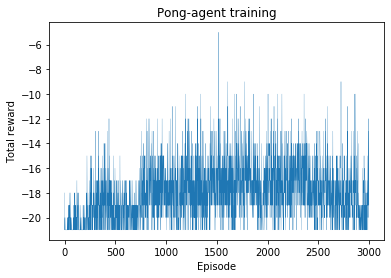

In [96]:
Y = np.array(reward_sum_history)
plt.plot(Y, linewidth=0.25)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.title('Pong-agent training')
plt.show()


In [58]:
!pip show matplotlib


Name: matplotlib
Version: 2.2.5
Summary: Python plotting package
Home-page: http://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/hannesengelbrecht/Library/Python/2.7/lib/python/site-packages
Requires: kiwisolver, subprocess32, cycler, six, backports.functools-lru-cache, pytz, numpy, pyparsing, python-dateutil
Required-by: 
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Demo

In [116]:
# Frame list collector
frames = []
STEPS = 3000

# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3

# initializing our environment
env = gym.make("Pong-v0")

# beginning of an episode
observation = env.reset()

In [117]:
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk.")

Loaded model from disk.


In [118]:
# main loop
for i in range(STEPS):    
    # choose action based on model's recommendation
    # preprocess the observation, set input as difference between images
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    proba = loaded_model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION

    #run one step
    observation, reward, done, info = env.step(action)
    frames.append(observation) # collecting observation

    # if episode is over, reset to beginning
    if done:
        observation = env.reset()
        frames.append(observation) # collecting observation

In [114]:
import matplotlib.pyplot as plt
from matplotlib import animation

def save_frames_as_gif(frames, filename=None):
    """
    Save a list of frames as a gif
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename:
        anim.save(filename, dpi=72, writer='imagemagick')

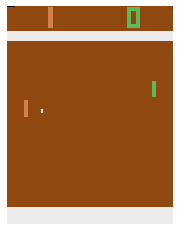

In [119]:
# from support import save_frames_as_gif
# Save the run
save_frames_as_gif(frames, filename='pong-agent demo.gif')

# Main file (.py)

In [38]:
# Main Python file for reviewers

# import relevant libs
import gym
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from matplotlib import animation
from support import save_frames_as_gif, prepro, summary_of_episodes """create a support.py file containing these two functions"""

# set up the environment
# Frame list collector
frames = []
STEPS = 1000

# code for the two only actions in Pong
UP_ACTION = 2
DOWN_ACTION = 3

# initializing our environment
env = gym.make("Pong-v0")
reward_sum = 0

# beginning of an episode
observation = env.reset()

# import model here
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk.")

# support function 1 - put in support.py file
# preprocessing used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def prepro(I):
    """prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector"""
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

# support function 2 - put in support.py file
# visualising the game
def save_frames_as_gif(frames, filename=None):
    """
    Save a list of frames as a gif
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])s
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename:
        anim.save(filename, dpi=72, writer='imagemagick')

# main loop
reward_sum_history_2 = []
for i in range(STEPS):
    # choose action based on model's recommendation
    # preprocess the observation, set input as difference between images
    cur_input = prepro(observation)
    x = cur_input - prev_input if prev_input is not None else np.zeros(80 * 80)
    prev_input = cur_input
    
    proba = loaded_model.predict(np.expand_dims(x, axis=1).T)
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION

    #run one step
    observation, reward, done, info = env.step(action)
    frames.append(observation) # collecting observation
    reward_sum += reward
    
    # if episode is over, reset to beginning
    if done:
        observation = env.reset()
        frames.append(observation) # collecting observation
        reward_sum_history_2.append(reward_sum)
        
        # increment episode number
        episode_nb += 1

        # Reinitialization
        rewards = [],[],[]
        observation = env.reset()
        reward_sum = 0
        prev_input = None

# print results to command line
summary_of_episodes(reward_sum_history)

# Save the run
save_frames_as_gif(frames, filename='pong-agent-demo.gif')